In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I have downloaded one of these detectors and stored it in the `haarcascades` directory.

Number of faces detected: 1


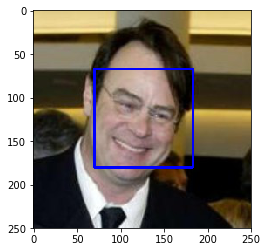

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

__Answer:__ 
(98% human faces detected in human_files_short and 17% human faces detected in dog_files_short)

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

bool_array1 = np.zeros((100,1))
count = 0

for i in range(len(human_files_short)):
    bool_array1[i] = face_detector(human_files_short[i])
    
count = np.count_nonzero(bool_array1)
print(count)

bool_array2 = np.zeros((100,1))
count = 0

for i in range(len(dog_files_short)):
    bool_array2[i] = face_detector(dog_files_short[i])
    
count = np.count_nonzero(bool_array2)
print(count)

98
17


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, I use a pre-trained model to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:20<00:00, 27217024.88it/s]


In [6]:
from PIL import Image
from torchvision.transforms import ToTensor

image = Image.open(dog_files_short[2])
print(type(image))
img = ToTensor()(image)
img = img.unsqueeze(0)
print(type(img))
print(img.shape)


<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'torch.Tensor'>
torch.Size([1, 3, 433, 250])


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell a function accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output will always be an integer between 0 and 999, inclusive.

In [7]:
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''

    ## Load and pre-process an image from the given img_path
    transformations = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
    
    image = Image.open(img_path)
    img = transformations(image)
    img = img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()
    
    ## Return the *index* of the predicted class for that image
    prediction = F.softmax(VGG16.forward(img), dim = 1)
    top_p, top_c = prediction.topk(1, dim = 1)
    predicted_class = int(top_c)
    
    return predicted_class # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

`dog_detector` function below returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    flag = False
    predicted_class = VGG16_predict(img_path)
    if ((predicted_class >= 151) and (predicted_class <= 268)):
        flag = True
    return flag # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
1. percentages of dogs detected in human_files_short: 0%
2. percentages of dogs detected in dog_files_short: 99%

In [9]:
count = 0
for img_path in dog_files_short:
    if (dog_detector(img_path) == True):
        count = count + 1        
print(count)

count = 0
for img_path in human_files_short:
    if (dog_detector(img_path) == True):
        count = count + 1        
print(count)


99
0


---
<a id='step4'></a>
## Create a CNN to Classify Dog Breeds (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify dog breed from images.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

the code cell below has write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

In [10]:
## TODO: Specify data loaders

import os
from torchvision import datasets
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets

data_dir = '/data/dog_images'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform = train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform = test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform = test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)

## Specify appropriate transforms, and batch_sizes

loaders_transfer = {
    'train': trainloader,
    'valid': validloader,
    'test': testloader
}

### (IMPLEMENTATION) Model Architecture


In [11]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture

model_transfer = models.resnet50(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = nn.Linear(2048, 133)

print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 44622027.19it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F


Selected a resnet50 pretrained model because it gives a really low top-1 loss and froze the parameters in all layers except the final classifying linear layer (fc) because resnet was trained on a very large dataset (compared to the dog dataset to be used over here) of images which included dogs too so the filters have been trained in identifying most of the higher level features of different kinds of dogs. The final layer can be customized into a breed classifier because most other dog features are learnt by the previous layers.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).

In [12]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr = 0.002)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [13]:
# train the model

def train1(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            logits = model(data)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            logits = model.forward(data)
            loss = criterion(logits, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            ## update the average validation loss

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if (valid_loss < valid_loss_min):
            print('Saving model now.../n')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            
    # return trained model
    return model

model_transfer = train1(15, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.734142 	Validation Loss: 1.158542
Saving model now.../n
Epoch: 2 	Training Loss: 1.793222 	Validation Loss: 0.800649
Saving model now.../n
Epoch: 3 	Training Loss: 1.680052 	Validation Loss: 0.905048
Epoch: 4 	Training Loss: 1.709251 	Validation Loss: 0.699655
Saving model now.../n
Epoch: 5 	Training Loss: 1.637529 	Validation Loss: 0.834259
Epoch: 6 	Training Loss: 1.603914 	Validation Loss: 0.904695
Epoch: 7 	Training Loss: 1.692248 	Validation Loss: 0.981438
Epoch: 8 	Training Loss: 1.606013 	Validation Loss: 0.994184
Epoch: 9 	Training Loss: 1.645307 	Validation Loss: 0.907698
Epoch: 10 	Training Loss: 1.594093 	Validation Loss: 0.665109
Saving model now.../n
Epoch: 11 	Training Loss: 1.656529 	Validation Loss: 0.994884
Epoch: 12 	Training Loss: 1.611438 	Validation Loss: 0.865346
Epoch: 13 	Training Loss: 1.552017 	Validation Loss: 0.906952
Epoch: 14 	Training Loss: 1.612760 	Validation Loss: 0.945070
Epoch: 15 	Training Loss: 1.647044 	Validation Loss: 

### (IMPLEMENTATION) Test the Model

the code cell below to calculate and print the test loss and accuracy.

In [14]:
def test1(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

test1(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.803909


Test Accuracy: 83% (701/836)


In [15]:

class_names = [item[4:].replace("_", " ") for item in train_data.classes]
print(class_names[0])

Affenpinscher


### (IMPLEMENTATION) Predict Dog Breed with the Model

function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [1]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    transformations = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
    
    image = Image.open(img_path)
    img = transformations(image)
    img = img.unsqueeze_(0)
    if use_cuda:
        img = img.cuda()
    
    ## Return the *index* of the predicted class for that image
    prediction = F.softmax(model_transfer.forward(img), dim = 1)
    top_p, top_c = prediction.topk(1, dim = 1)
    predicted_class = int(top_c)
    
    return class_names[predicted_class]

NameError: name 'train_data' is not defined

---
<a id='step5'></a>
## Step 5: Algorithm

 an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [17]:
import matplotlib.pyplot as plt 
def display_image(img_path):
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()

In [21]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    display_image(img_path)
    if (face_detector(img_path) == True):
        breed = predict_breed_transfer(img_path)
        print("Hello human. You look like a: ",breed)
    
    if (dog_detector(img_path) == True):
        breed = predict_breed_transfer(img_path)
        print("It's a breed of dog: ",breed)
        
    if ((face_detector(img_path) == False) and (dog_detector(img_path) == False)):
        print("Neither human nor dog: error")


---
<a id='step6'></a>
## Test Your Algorithm

In this section, take this new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Algorithm on Sample Images!  

5 possible points for improvement
Output is certainly better than expected. It gives the correct breed of dogs in the pictures. Accuracy was 82% and I feel that can be improved.
1. Increase the number of fully connected layers
3. Using a network like Wide resnet 50 because that has given lower top 1 loss might be a better idea
4. Running for more epochs with a lower learning rate
5. Using better weight initialization

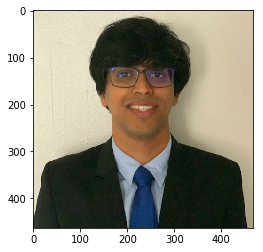

Hello human. You look like a:  Cairn terrier


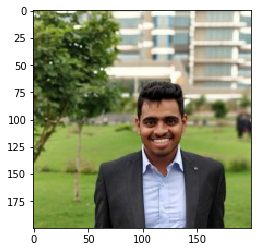

Hello human. You look like a:  German shepherd dog


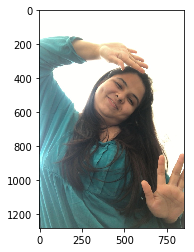

Neither human nor dog: error


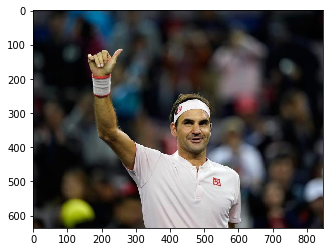

Hello human. You look like a:  Airedale terrier


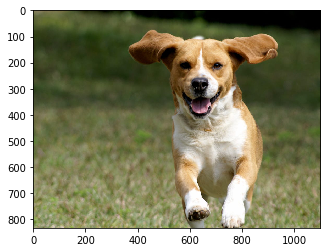

It's a breed of dog:  Nova scotia duck tolling retriever


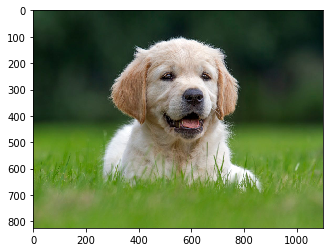

It's a breed of dog:  Golden retriever


In [22]:
random_pics = ['./images/linkedin.jpg', './images/vignesh.jpg', './images/ruk.jpg', './images/roger.jpg' ] 
dog_pics = ['./images/dog1.jpg', './images/dog.jpg']   
for file in np.hstack((random_pics, dog_pics)):     
        run_app(file)